In [78]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
%matplotlib inline
from scipy.stats import chi2_contingency
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [79]:
data1=pd.read_csv("heart.csv")
data2=pd.read_csv("insurance.csv")

In [80]:
gender_encoding={'female' : 0,'male': 1}
data2['sex'] =data2['sex'].map(gender_encoding) 
data2.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,yes,southwest,16884.92400
1,18,1,33.770,1,no,southeast,1725.55230
2,28,1,33.000,3,no,southeast,4449.46200
3,33,1,22.705,0,no,northwest,21984.47061
4,32,1,28.880,0,no,northwest,3866.85520


In [81]:
data1.rename(columns={'target':'heart disease'},inplace=True)
data1.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'heart disease'],
      dtype='object')

In [82]:
df_all=pd.merge(data1,data2,on=['age','sex'],how='inner')
df_all=df_all.drop_duplicates()
df_all.shape

(3411, 19)

In [83]:
numerical_continuous=[] 
for column in df_all.columns:
    if df_all[column].dtypes !='object':
        if df_all[column].nunique() >=10:
            numerical_continuous.append(column)
numerical_continuous.remove('charges') 
numerical_continuous

['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'bmi']

In [84]:
numerical_discrete=[] 
for column in df_all.columns:
    if df_all[column].dtypes !='object':
        if df_all[column].nunique() < 10:
            numerical_discrete.append(column)
numerical_discrete.remove('heart disease') 
numerical_discrete

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'children']

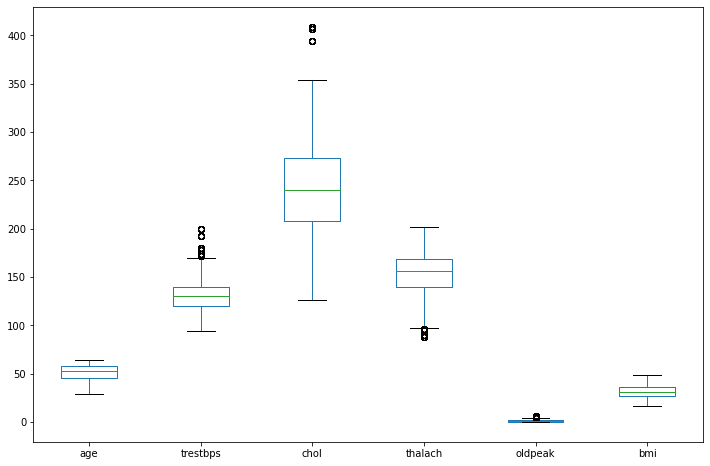

In [85]:
df_all[numerical_continuous].plot (kind ='box',figsize=(12,8))

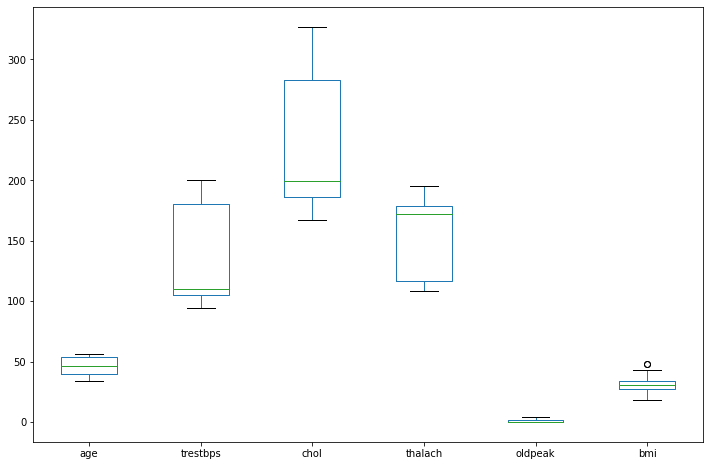

In [86]:
p_value=0.7
zscore=np.abs(stats.zscore(df_all[['trestbps', 'chol', 'thalach', 'oldpeak']]))
df_all[(zscore > p_value).all(axis=1)][numerical_continuous].plot (kind ='box',figsize=(12,8))

In [87]:
df_all[(zscore > p_value).all(axis=1)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart disease,bmi,children,smoker,region,charges
70,41,0,1,105,198,0,1,168,0,0.0,2,1,2,1,32.965,0,no,northwest,6571.02435
71,41,0,1,105,198,0,1,168,0,0.0,2,1,2,1,31.600,0,no,southwest,6186.12700
72,41,0,1,105,198,0,1,168,0,0.0,2,1,2,1,33.155,3,no,northeast,8538.28845
73,41,0,1,105,198,0,1,168,0,0.0,2,1,2,1,32.200,1,no,southwest,6775.96100
74,41,0,1,105,198,0,1,168,0,0.0,2,1,2,1,37.100,2,no,southwest,7371.77200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3153,39,0,2,94,199,0,1,179,0,0.0,2,0,2,1,23.275,3,no,northeast,7986.47525
3154,39,0,2,94,199,0,1,179,0,0.0,2,0,2,1,34.100,3,no,southwest,7418.52200
3155,39,0,2,94,199,0,1,179,0,0.0,2,0,2,1,18.300,5,yes,southwest,19023.26000
3156,39,0,2,94,199,0,1,179,0,0.0,2,0,2,1,23.870,5,no,southeast,8582.30230


In [88]:
cols= numerical_continuous
pmax=1
while(len(cols) > 0):
    p=[]
    x_1=df_all[cols]
    x_1=sm.add_constant(x_1)
    model=sm.OLS(df_all['charges'],x_1).fit()
    p=pd.Series(model.pvalues.values[1:],index=cols)
    pmax=max(p)
    feature_with_p_max=p.idxmax()
    if(pmax > 0.05):
        cols.remove(feature_with_p_max)
    else:
        break
    numerical_continuous_selected=cols
    print(numerical_continuous_selected)

['age', 'trestbps', 'chol', 'thalach', 'bmi']
['age', 'trestbps', 'thalach', 'bmi']
['age', 'trestbps', 'bmi']
['age', 'bmi']


In [89]:
categorical=['smoker','region']
for columns in df_all.columns:
    if df_all[column].dtypes=='object':
        categorical.append(column)
categorical

['smoker', 'region']

In [90]:
chi2_check=[]
for i in categorical+numerical_discrete:
    if chi2_contingency(pd.crosstab(df_all['heart disease'],df_all[i]))[1] < 0.05:
        chi2_check.append("Reject Null Hypothesis")
    else:
            chi2_check.append(" Fail to Reject Null Hypothesis")
res=pd.DataFrame(data=[categorical+numerical_discrete,chi2_check]).T
res.column=['column','Hypothesis']
print(res)

           0                                1
0     smoker   Fail to Reject Null Hypothesis
1     region   Fail to Reject Null Hypothesis
2        sex           Reject Null Hypothesis
3         cp           Reject Null Hypothesis
4        fbs   Fail to Reject Null Hypothesis
5    restecg           Reject Null Hypothesis
6      exang           Reject Null Hypothesis
7      slope           Reject Null Hypothesis
8         ca           Reject Null Hypothesis
9       thal           Reject Null Hypothesis
10  children           Reject Null Hypothesis


<ipython-input-90-d01e27f884b5>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  res.column=['column','Hypothesis']


In [91]:
df_all.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'heart disease', 'bmi',
       'children', 'smoker', 'region', 'charges'],
      dtype='object')

In [118]:
df__all=df_all.drop(['smoker','region'], axis = 1)

In [119]:
df_regression=df__all.drop(['charges'], axis = 1)

In [120]:
df_regression

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,heart disease,bmi,children
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,28.310,0
1,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,35.090,0
2,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,41.470,0
3,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,36.765,0
4,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,41.325,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3418,59,0,0,174,249,0,1,143,1,0.0,1,0,2,0,32.100,3
3419,59,0,0,174,249,0,1,143,1,0.0,1,0,2,0,31.350,0
3420,59,0,0,174,249,0,1,143,1,0.0,1,0,2,0,26.695,3
3421,59,0,0,174,249,0,1,143,1,0.0,1,0,2,0,27.500,0


In [121]:
df_classification=df__all.drop(['heart disease'], axis = 1)
df_classification

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,bmi,children,charges
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,28.310,0,13770.09790
1,63,1,3,145,233,1,0,150,0,2.3,0,0,1,35.090,0,47055.53210
2,63,1,3,145,233,1,0,150,0,2.3,0,0,1,41.470,0,13405.39030
3,63,1,3,145,233,1,0,150,0,2.3,0,0,1,36.765,0,13981.85035
4,63,1,3,145,233,1,0,150,0,2.3,0,0,1,41.325,3,15555.18875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3418,59,0,0,174,249,0,1,143,1,0.0,1,0,2,32.100,3,14007.22200
3419,59,0,0,174,249,0,1,143,1,0.0,1,0,2,31.350,0,12622.17950
3420,59,0,0,174,249,0,1,143,1,0.0,1,0,2,26.695,3,14382.70905
3421,59,0,0,174,249,0,1,143,1,0.0,1,0,2,27.500,0,12233.82800


In [122]:
df_classification.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3411 entries, 0 to 3422
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       3411 non-null   int64  
 1   sex       3411 non-null   int64  
 2   cp        3411 non-null   int64  
 3   trestbps  3411 non-null   int64  
 4   chol      3411 non-null   int64  
 5   fbs       3411 non-null   int64  
 6   restecg   3411 non-null   int64  
 7   thalach   3411 non-null   int64  
 8   exang     3411 non-null   int64  
 9   oldpeak   3411 non-null   float64
 10  slope     3411 non-null   int64  
 11  ca        3411 non-null   int64  
 12  thal      3411 non-null   int64  
 13  bmi       3411 non-null   float64
 14  children  3411 non-null   int64  
 15  charges   3411 non-null   float64
dtypes: float64(3), int64(13)
memory usage: 453.0 KB


In [123]:
df_classification.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
bmi         0
children    0
charges     0
dtype: int64

In [124]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X=scaler.fit_transform(df_classification)
y=df_all['heart disease']
X=scaler.fit_transform(df_regression)
y=df_all['charges']


In [125]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [126]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2728, 16)
(683, 16)
(2728,)
(683,)


In [127]:

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.svm  import SVC

In [129]:
#regression
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X_train,y_train)
linear.score(X_test,y_test)

0.0108710095893364

In [130]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
tree.fit(X_train,y_train)
tree.score(X_test,y_test)

0.6687235084482306

In [140]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor()
ada.fit(X_train,y_train)
ada.score(X_test,y_test)

-0.14571643489979258

In [144]:
X_train_std = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [146]:
X_train_std

array([[ 0.65653015,  0.65442513,  1.01899191, ...,  0.87831007,
         1.50780831, -0.91531832],
       [ 1.04692779,  0.65442513, -0.94762283, ..., -1.13855009,
        -0.3074848 , -0.91531832],
       [-0.38453023,  0.65442513,  1.01899191, ..., -1.13855009,
        -0.46820506,  1.63783952],
       ...,
       [-0.64479532,  0.65442513,  1.01899191, ...,  0.87831007,
        -1.02311293, -0.0642657 ],
       [ 0.26613251, -1.52805868,  1.01899191, ...,  0.87831007,
        -0.64499735, -0.0642657 ],
       [ 0.91679525,  0.65442513, -0.94762283, ..., -1.13855009,
        -1.14323018, -0.91531832]])

In [149]:
X_test

array([[ 1.03264667,  0.65020783, -0.9572597 , ..., -1.15577326,
        -1.22325873, -0.05808468],
       [-0.7728022 ,  0.65020783, -0.9572597 , ..., -1.15577326,
         2.13212469,  1.6417149 ],
       [ 0.51680413, -1.53784302, -0.9572597 , ..., -1.15577326,
        -0.83234028, -0.05808468],
       ...,
       [ 1.41952857,  0.65020783, -0.9572597 , ..., -1.15577326,
         1.71720247, -0.90798447],
       [-0.12799903,  0.65020783,  1.00350146, ...,  0.86481992,
         1.96238378,  0.79181511],
       [ 0.3878435 ,  0.65020783, -0.9572597 , ..., -1.15577326,
         0.20839439, -0.05808468]])

In [151]:
y_train

289     10982.50130
3342    12730.99960
964     10264.44210
3251     4747.05290
342     10959.33000
           ...     
2507    11946.62590
1397    12124.99240
2201    21978.67690
1829    11305.93455
1336    12323.93600
Name: charges, Length: 2728, dtype: float64

In [152]:
y_test

3381    13112.60480
2979     8944.11510
462     12044.34200
923     11015.17470
2347    14254.60820
           ...     
944      9290.13950
203     26109.32905
24      13405.39030
1642    47462.89400
3116    10807.48630
Name: charges, Length: 683, dtype: float64

In [153]:
#Classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [155]:
classifiers={
    "LogisticRegression":LogisticRegression(),
    "RandomForestClassifier":RandomForestClassifier(),
    "SVC":SVC(),
    "KNeighborsClassifier":KNeighborsClassifier()
}

In [160]:
train_score=[]
test_score=[]
for key, classifier in classifiers.items():
    classifier.fit(X_train,y_train)
    train_score=round(classifier.score(X_train,y_train),2)
    train_score.append(train_score)
    test_score=round(classifier.score(X_train,y_train),2)
    test_score.append(test_score)

ValueError: Unknown label type: 'continuous'